In [91]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture
import nltk
from nltk import word_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from gensim.parsing.preprocessing import remove_stopwords
from gensim import corpora
from gensim.models import LsiModel, CoherenceModel, LdaModel
import contractions
import wordcloud
from autocorrect import Speller
import pyLDAvis
import pyLDAvis.gensim_models
import warnings
from operator import itemgetter
warnings.filterwarnings('ignore')

(494485, 12)
(494196, 12)


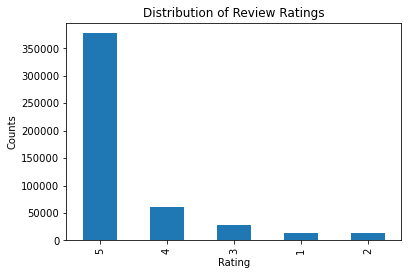

(100000, 12)


In [16]:
#  Load the main dataset
office_prods = pd.read_json('Arts_Crafts_and_Sewing_5.json', lines=True)
print(office_prods.shape)

#  lowercase and normalize the column names, remove missing values
office_prods.columns = office_prods.columns.str.strip().str.lower()
office_prods = office_prods[office_prods['reviewtext'].notna()]
print(office_prods.shape)

#  visualize data to see the frequency of ratings
office_prods['overall'].value_counts().plot.bar()
plt.title('Distribution of Review Ratings')
plt.xlabel('Rating')
plt.ylabel('Counts')
plt.show()

#  Take a subsample of the dataset - 100,000 reviews
office_prods = office_prods.sample(100000, weights='overall', random_state=0).reset_index(drop=True)
print(office_prods.shape)

#  visualize data to see the frequency of ratings
# office_prods['overall'].value_counts().plot.bar()
# plt.title('Distribution of Review Ratings')
# plt.xlabel('Rating')
# plt.ylabel('Counts')
# plt.show()

#  check if there are multiple entries per user
duplicates_reviewers = office_prods.pivot_table(columns=['reviewerid'], aggfunc='size')
duplicates_prods = office_prods.pivot_table(columns=['asin'], aggfunc='size')
#print(duplicates_prods.sort_values(ascending=False))


In [102]:

#  ----- PREPROCESSING ----

#  preprocess and lemmatize the reviews before running TFIDF
tokenizer = RegexpTokenizer(r'[A-Za-z]+')
lemmatizer = WordNetLemmatizer()
autocorrect = Speller(fast=True)
words = set(nltk.corpus.words.words())


#  autocorrect
#office_prods['reviewtext'] = office_prods['reviewtext'].apply(lambda x: autocorrect(x))

#  expand contractions
office_prods['reviewtext'] = office_prods['reviewtext'].apply(lambda x: x.split())
office_prods['reviewtext'] = office_prods['reviewtext'].apply(lambda x: " ".join([contractions.fix(word) for word in x]))

#  apply lowercase
office_prods['reviewtext'] = office_prods['reviewtext'].apply(lambda x: x.lower())

#  remove stopwords
office_prods['reviewtext'] = office_prods['reviewtext'].apply(lambda x: remove_stopwords(x))

#  tokenize the text
office_prods['reviewtext'] = office_prods['reviewtext'].apply(lambda x: tokenizer.tokenize(x))

#  remove the recurring unnecessary words like love, good, great
misc_words = ['love', 'great', 'good']
office_prods['reviewtext'] = office_prods['reviewtext'].apply(lambda x: [word for word in x if word not in misc_words])

#  lemmatize - keep two versions - the original dataset should have cleaned reviews while a new df would have tokenized
#  reviews (review_tokens)
reviews_tokens = office_prods['reviewtext'].apply(lambda x: [lemmatizer.lemmatize(word, 'v') for word in x])
office_prods['reviewtext'] = office_prods['reviewtext'].apply(lambda x: " ".join([lemmatizer.lemmatize(word, 'v') for word in x]))


#print(office_prods['reviewtext'].head())

#  vectorize the review text data

#  remove words that occur in less than 1000 documents by setting the min_df parameter
min_df = 1000/len(office_prods)

#  vectorize using tfidf
vectorizer = TfidfVectorizer(min_df=min_df, token_pattern=r'[a-z]+', stop_words='english')
tfidf = vectorizer.fit_transform(office_prods['reviewtext'])
tfidf = pd.DataFrame(tfidf.toarray(), columns=vectorizer.get_feature_names())

#  vectorize using count-vectorizer  
count_vectorizer = CountVectorizer(min_df=min_df, token_pattern=r'[a-z]+', stop_words='english')
cv = count_vectorizer.fit_transform(office_prods['reviewtext'])
cv = pd.DataFrame(cv.toarray(), columns=count_vectorizer.get_feature_names())
office_prods_tokens = pd.concat([office_prods, tfidf], axis=1)
print(cv.shape)


(100000, 195)


In [103]:
print(reviews_tokens)

0        [nice, fabric, ribbons, little, roll, ribbon, ...
1                                [super, glue, book, bind]
2        [stamp, impressions, surface, darling, image, ...
3                [work, size, price, fuse, fabrics, quilt]
4                                    [order, wrong, color]
                               ...                        
99995    [quality, art, tool, plain, fun, work, play, s...
99996    [finally, dritz, bodkin, work, better, safety,...
99997    [surprise, come, package, use, card, scrapbook...
99998                                    [excellent, core]
99999                     [bead, scratch, hopefully, buff]
Name: reviewtext, Length: 100000, dtype: object


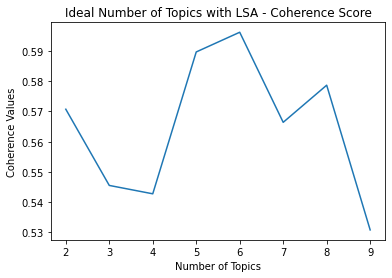

In [116]:
#  ---- LSA with Gensim ----

#  convert the tokenized reviews into a list of lists
reviews = reviews_tokens.tolist()

#  create a dictionary out of it
dictionary = corpora.Dictionary(reviews)

#  create a doc-term matrix
doc_term_matrix = [dictionary.doc2bow(doc) for doc in reviews]

#  create a gensim LSA model
n_topics = 10

#  get coherence scores to get the optimum number of topics
coherence_vals = []

for topic in range(2, n_topics):
    #  run an LSA model for each topic value
    model = LsiModel(doc_term_matrix, num_topics=topic, id2word=dictionary)
    #  create a coherence model
    coherence_model = CoherenceModel(model=model, texts=reviews, dictionary=dictionary, coherence='c_v')
    coherence_vals.append(coherence_model.get_coherence())

x = range(2, n_topics)
plt.plot(x, coherence_vals)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Values")
plt.title('Ideal Number of Topics with LSA - Coherence Score')
plt.show()

In [106]:
#  Keep the number of topics as 5 - Arts crafts data
lsa = LsiModel(doc_term_matrix, num_topics=5, id2word=dictionary)

topics = lsa.print_topics(num_topics=5, num_words=5)

for topic in topics:
    print(topic)

(0, '0.342*"use" + 0.323*"color" + 0.256*"machine" + 0.231*"work" + 0.215*"like"')
(1, '-0.581*"color" + 0.515*"machine" + -0.223*"pencil" + 0.221*"sew" + 0.194*"thread"')
(2, '-0.521*"color" + -0.397*"machine" + -0.257*"thread" + 0.257*"cut" + 0.227*"paper"')
(3, '-0.430*"paper" + -0.358*"cut" + 0.329*"brush" + 0.275*"paint" + -0.219*"pencil"')
(4, '0.423*"hook" + -0.360*"brush" + 0.317*"link" + -0.293*"paint" + 0.277*"crochet"')


In [123]:
#  Extracting topics from LSA 

doc_topics_lsa = []
for i in range(len(doc_term_matrix)):
    topics = lsa[doc_term_matrix[0]]
    topic = max(topics, key=itemgetter(1))[0]
    doc_topics_lsa.append(topic)


lsa[doc_term_matrix[0]]



[(0, 0.4668439559558041),
 (1, -0.012930963454024703),
 (2, 0.12336405820866274),
 (3, 0.13590051002338027),
 (4, -0.0012682289427523776)]

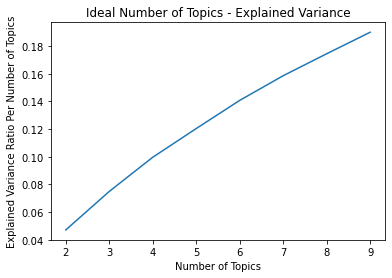

In [109]:
#  --- LSA via SVD ---

n_topics = 10

svd_variance = []
for topic in range(2, n_topics):
    #  run SVD for all the possibke number of topics
    svd = TruncatedSVD(n_components=topic)
    svd_lsa = svd.fit_transform(tfidf)
    variance = svd.explained_variance_ratio_.sum()
    svd_variance.append(variance)

x = range(2, n_topics)
plt.plot(x, svd_variance)
plt.xlabel("Number of Topics")
plt.ylabel("Explained Variance Ratio Per Number of Topics")
plt.title('Ideal Number of Topics - Explained Variance')
plt.show()

svd = TruncatedSVD(n_components= 5)
svd_lsa = svd.fit_transform(tfidf)

topic_encoded_df = pd.DataFrame(svd_lsa, columns = ["1", "2", "3", "4", "5"])
topic_encoded_df['assigned_topic'] = topic_encoded_df.idxmax(axis=1)
topic_encoded_df.insert(0, 'review', office_prods['reviewtext'])




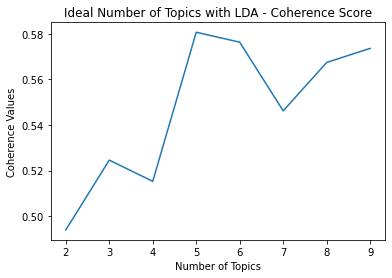

In [126]:
#  ---- Topic Modelling with LDA ----

coherence_vals = []

for topic in range(2, n_topics):
    #  run an LDA model for each topic value
    model = LdaModel(doc_term_matrix, num_topics=topic, id2word=dictionary)
    #  create a coherence model
    coherence_model = CoherenceModel(model=model, texts=reviews, dictionary=dictionary, coherence='c_v')
    coherence_vals.append(coherence_model.get_coherence())

x = range(2, n_topics)
plt.plot(x, coherence_vals)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Values")
plt.title('Ideal Number of Topics with LDA - Coherence Score')
plt.show()


In [127]:
#  Sticking to 5 topics as changing from 5 to 7 doesn't affect the coherence value much

lda = LdaModel(doc_term_matrix,id2word=dictionary,num_topics=5)
topics = lda.print_topics(num_topics=5, num_words=5)
for topic in topics:
    print(topic)

(0, '0.034*"product" + 0.033*"price" + 0.028*"machine" + 0.024*"quality" + 0.022*"buy"')
(1, '0.086*"color" + 0.022*"set" + 0.016*"paper" + 0.016*"pencil" + 0.015*"nice"')
(2, '0.040*"cut" + 0.023*"card" + 0.022*"use" + 0.019*"bead" + 0.017*"die"')
(3, '0.027*"work" + 0.019*"like" + 0.014*"use" + 0.012*"needle" + 0.011*"yarn"')
(4, '0.037*"use" + 0.026*"paint" + 0.022*"brush" + 0.018*"easy" + 0.016*"perfect"')


In [128]:
#  Visualize - this code is giving an error so need to figure out how to print

pyLDAvis.enable_notebook()

lda_vis = pyLDAvis.gensim_models.prepare(lda, corpus=doc_term_matrix, dictionary=dictionary)
lda_vis


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.064671 -0.125871       1        1  29.271824
0     -0.098007 -0.072521       2        1  19.243056
4      0.054926 -0.118282       3        1  18.941766
1     -0.209428  0.130778       4        1  17.161161
2      0.187836  0.185897       5        1  15.382192, topic_info=        Term          Freq         Total Category  logprob  loglift
32     color  17899.000000  17899.000000  Default  30.0000  30.0000
175      cut   8066.000000   8066.000000  Default  29.0000  29.0000
28     price   8252.000000   8252.000000  Default  28.0000  28.0000
48   machine   6866.000000   6866.000000  Default  27.0000  27.0000
149    paint   7019.000000   7019.000000  Default  26.0000  26.0000
..       ...           ...           ...      ...      ...      ...
201     easy   1212.939340   8197.460755   Topic5  -5.0261  -0.0388
301    craft   1007.051117   3754.631504   Topic5  -5.2121   0.5560
145     like   1084.646488  13039.916190   Topic5  -5.1379  -0.6148
6       nice   1059.195360  10628.010832   Topic5  -5.1616  -0.4340
288     tool    965.454509   3268.545325   Topic5  -5.2543   0.6525

[410 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
798       1  0.017290   acrylic
798       3  0.978092   acrylic
798       4  0.003705   acrylic
2630      3  0.995784  acrylics
238       1  0.056962       add
...     ...       ...       ...
1187      5  0.682311         x
117       1  0.668239      yarn
117       2  0.001328      yarn
117       3  0.084131      yarn
117       4  0.246255      yarn

[948 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 1, 5, 2, 3])

In [87]:
#  Get LDA topics for each document 

doc_topics_lda = []
for i in range(len(doc_term_matrix)):
    topics = lda[doc_term_matrix[0]]
    topic = max(topics, key=itemgetter(1))[0]
    doc_topics_lda.append(topic)

set(doc_topics_lda)

{2}

In [8]:
# ---- Clustering with DBSCAN ----

#dbscan = DBSCAN(eps=0.5, min_samples=50, n_jobs=-1)
#cl_db = dbscan.fit(tfidf)
#labels = cl_db.labels_
#print(set(labels))


{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, -1}


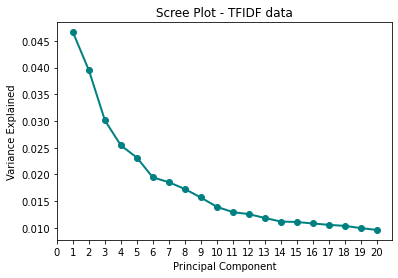

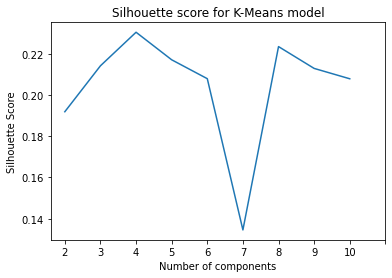

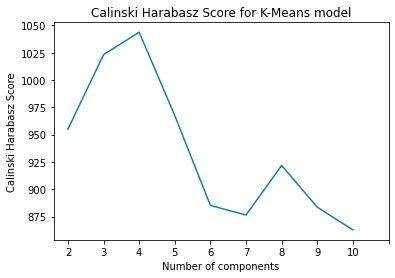

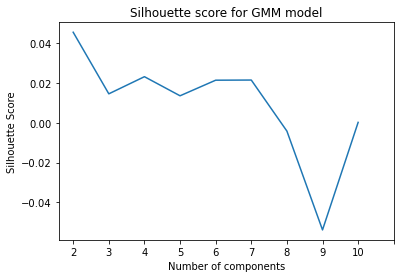

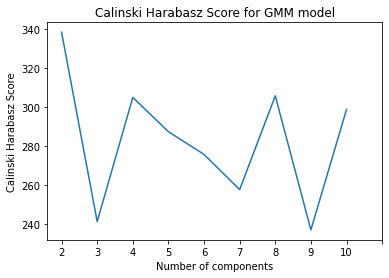

In [17]:
#  ---- Clustering ----

#  IMPORTANT:
#  Only a subset of data - 10,000 reviews are used while running the clustering algorithms

#  parameters to change:
components = 20 #  dimensions
clusters = 10 #  number of clusters


def scree_plot(data, n):
    """
    Create a scree plot from the given data after running PCA on it
    :param data: tfidf data
    :param n: number of dimensions to test
    :return: scree plot
    """
    #  Apply PCA to check how many dimensions to reduce the data down to
    pca = PCA(n_components=n, random_state=0)

    #  Fit the model
    pca.fit(data)

    #  Plot the scree plot for PCA
    PCA_values = np.arange(pca.n_components_) + 1
    plt.plot(PCA_values, pca.explained_variance_ratio_, 'o-', linewidth=2, color='teal')
    ticks = [x for x in range(n + 1)]
    plt.title(f'Scree Plot - TFIDF data')
    plt.xlabel('Principal Component')
    plt.xticks(ticks, ticks)
    plt.ylabel('Variance Explained')
    plt.show()

#  scree plot
scree_plot(tfidf, components)


#  dimensionality reduction of text data with SVD

svd = TruncatedSVD(n_components=components)
tfidf_rd = pd.DataFrame(svd.fit_transform(tfidf))


#  take a subset of the dataset - can be altered
subsample = tfidf_rd.sample(10000, random_state=0)
#subsample = tfidf.sample(10000, random_state=0)

#  find the right number of clusters with different types of clustering
    
def silhouette_score_plot(score, model):
    """
    plot out silhouette score
    param score: list of scores
    """
    plt.plot(score)
    plt.ylabel('Silhouette Score')
    plt.xlabel('Number of components')
    plt.title(f'Silhouette score for {model} model')
    plt.xticks(np.arange(clusters), np.arange(2, clusters+1))
    plt.show()
    
def CH_score_plot(score, model):
    """
    plot out Calinski Harabasz score
    param score: list of scores
    """
    plt.plot(score)
    plt.ylabel('Calinski Harabasz Score')
    plt.xlabel('Number of components')
    plt.title(f'Calinski Harabasz Score for {model} model')
    plt.xticks(np.arange(clusters), np.arange(2, clusters+1))
    plt.show()
    
#  --- K Means ---

sil_score_k = []
ch_index_k = []

for k in np.arange(2, clusters + 1):
    kmeans = KMeans(n_clusters=k, random_state=0).fit(subsample)
    labels = np.array(kmeans.labels_)
    #  calculate the silhouette score for each component selection
    silhouette = silhouette_score(subsample, labels)
    ch = calinski_harabasz_score(subsample, labels)
    sil_score_k.append(silhouette)
    ch_index_k.append(ch)

silhouette_score_plot(sil_score_k, 'K-Means')
CH_score_plot(ch_index_k, 'K-Means')
    
#  --- GMM ---

sil_score_gmm = []
ch_index_gmm = []

for k in np.arange(2, clusters + 1):
    gmm = GaussianMixture(n_components=k, random_state=0).fit(subsample)
    labels = np.array(gmm.predict(subsample))
    #  calculate the silhouette score for each component selection
    silhouette = silhouette_score(subsample, labels)
    ch = calinski_harabasz_score(subsample, labels)
    sil_score_gmm.append(silhouette)
    ch_index_gmm.append(ch)

silhouette_score_plot(sil_score_gmm, 'GMM')
CH_score_plot(ch_index_gmm, 'GMM')